In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import shelf
from time import time

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=500,
#     ms_between_distance=100,
#     max_epi_distance=40,
#     gp_max_radius=60,
#     pp_conflict_overlap=0.8
# )


# params = get_settings(
#     ms_radius=300,
#     ms_between_distance=60,
#     max_epi_distance=40, 
#     scale_to_mm=1000, 
#     gp_max_radius=60,
#     pp_conflict_overlap=0.8)

params = get_settings(
    hm_detection_threshold=0.1,
    ms_radius=250,
    ms_between_distance=70,
    max_epi_distance=10, 
    scale_to_mm=1000, 
    gp_max_radius=50,
    pp_conflict_overlap=0.8)


loader = Loader(with_gpu=True)
# =====================================

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)

def proper_pcp_calc(Y, Humans):
    alpha = 0.5
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs
    
    
def generate_pcp_score(frame):
    global Settings, params
    
    Im, Y, Calib = shelf.get(root, frame)
    
    # -- reduce #cams
#     Calib = Calib[0:3]
#     Y = Y[0:3]
#     Im = Im[0:3]
    # --------------
    
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'shelf', Im, frame, dir=Settings['tmp'])
    detections = pose.estimate(Calib, heatmaps, pafs, 
                               settings=params, debug=False)

    # ohne PC
    Humans = kth.transform3d_from_mscoco(detections)
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = proper_pcp_calc(Y, Humans)
    Ohne = (L_Arms, U_Arms, L_Legs, U_Legs, GTIDs)
    
    # mit 
    if len(detections) > 0:
        detections = gen.apply(detections)
        Humans = kth.transform3d_from_mscoco(detections)
        L_Arms2, U_Arms2, L_Legs2, U_Legs2, GTIDs2 = proper_pcp_calc(Y, Humans)
        Mit = (L_Arms2, U_Arms2, L_Legs2, U_Legs2, GTIDs2)
    else:
        n = len(Y)
        LA = [0] * n
        UA = [0] * n
        LL = [0] * n
        UL = [0] * n
        FR = [frame] * n
        Mit = (LA, UA, LL, UL, FR)
            
    # --

    return Ohne, Mit
    #return Ohne

# =====================================

valid_frames = list(range(300, 600, 1))
#valid_frames = list(range(300, 302))
PER_GTID = {}
PER_GTID_PC = {}
# FRAMES = []
# AVG = []


def build(per_gtid, obj):
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = obj
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in per_gtid:
                per_gtid[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            per_gtid[gtid]['larms'].append(larms)
            per_gtid[gtid]['uarms'].append(uarms)
            per_gtid[gtid]['llegs'].append(llegs)
            per_gtid[gtid]['ulegs'].append(ulegs)
            per_gtid[gtid]['frame'].append(frame)

for frame in valid_frames:
    _start = time()
    Ohne, Mit = generate_pcp_score(frame)
    #Ohne = generate_pcp_score(frame)
    _end = time()
    print('frame ' + str(frame) + ', elapsed:', _end - _start)
    build(PER_GTID, Ohne)
    build(PER_GTID_PC, Mit)
#     FRAMES.append(frame)
#     AVG.append((larms + uarms + llegs + ulegs)/4)


Using TensorFlow backend.


frame 300, elapsed: 13.381019830703735
frame 301, elapsed: 9.936818599700928
frame 302, elapsed: 9.671647548675537
frame 303, elapsed: 9.610235691070557
frame 304, elapsed: 9.65388035774231
frame 305, elapsed: 9.633462190628052
frame 306, elapsed: 9.8169584274292
frame 307, elapsed: 9.826012134552002
frame 308, elapsed: 9.83713698387146
frame 309, elapsed: 9.755969762802124
frame 310, elapsed: 9.765929937362671
frame 311, elapsed: 9.889940738677979
frame 312, elapsed: 9.788808822631836
frame 313, elapsed: 10.357153415679932
frame 314, elapsed: 10.521175622940063
frame 315, elapsed: 10.454801321029663
frame 316, elapsed: 11.42197060585022
frame 317, elapsed: 11.194185495376587
frame 318, elapsed: 10.704855680465698
frame 319, elapsed: 10.185890197753906
frame 320, elapsed: 11.626715421676636
frame 321, elapsed: 11.790019989013672
frame 322, elapsed: 12.167067050933838
frame 323, elapsed: 12.70133352279663
frame 324, elapsed: 11.463328123092651
frame 325, elapsed: 11.413363695144653
fram

frame 513, elapsed: 10.07114577293396
frame 514, elapsed: 10.13292407989502
frame 515, elapsed: 9.943181991577148
frame 516, elapsed: 10.062555074691772
frame 517, elapsed: 10.314084529876709
frame 518, elapsed: 10.158371210098267
frame 519, elapsed: 10.078205108642578
frame 520, elapsed: 10.072413206100464
frame 521, elapsed: 10.221204042434692
frame 522, elapsed: 10.21372365951538
frame 523, elapsed: 10.156806707382202
frame 524, elapsed: 10.303810358047485
frame 525, elapsed: 10.73035740852356
frame 526, elapsed: 11.979730606079102
frame 527, elapsed: 11.067365407943726
frame 528, elapsed: 11.054054737091064
frame 529, elapsed: 11.235186100006104
frame 530, elapsed: 11.49717664718628
frame 531, elapsed: 10.362149715423584
frame 532, elapsed: 10.75540280342102
frame 533, elapsed: 10.39859127998352
frame 534, elapsed: 10.26061224937439
frame 535, elapsed: 10.596113920211792
frame 536, elapsed: 10.194828987121582
frame 537, elapsed: 10.309470891952515
frame 538, elapsed: 10.61145234107

In [2]:
print("-----Without PC-----")
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

print("\n-----With PC-----")
total_avg = []
for key, values in PER_GTID_PC.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

-----Without PC-----
actor  0
	uarms: 0.9731182795698925
	larms: 0.9157706093189965
	ulegs: 0.9874551971326165
	llegs: 0.978494623655914
	avg:   0.9637096774193549
actor  2
	uarms: 0.9316770186335404
	larms: 0.9472049689440993
	ulegs: 0.9968944099378882
	llegs: 0.9937888198757764
	avg:   0.9673913043478262
actor  1
	uarms: 0.8378378378378378
	larms: 0.4189189189189189
	ulegs: 0.9324324324324325
	llegs: 0.9324324324324325
	avg:   0.7804054054054055

avg*:   0.9038354623908621

-----With PC-----
actor  0
	uarms: 0.974910394265233
	larms: 0.9480286738351255
	ulegs: 0.9874551971326165
	llegs: 0.985663082437276
	avg:   0.9740143369175627
actor  2
	uarms: 0.9347826086956522
	larms: 0.9472049689440993
	ulegs: 0.9968944099378882
	llegs: 0.9937888198757764
	avg:   0.9681677018633541
actor  1
	uarms: 0.8648648648648649
	larms: 0.4864864864864865
	ulegs: 1.0
	llegs: 0.9324324324324325
	avg:   0.8209459459459459

avg*:   0.9210426615756209


In [3]:
# Prof. Galls idea:
# params = get_settings(
#     ms_radius=300,
#     ms_between_distance=60,
#     max_epi_distance=40, 
#     scale_to_mm=1000, 
#     gp_max_radius=60,
#     pp_conflict_overlap=0.8)
# 
# NO THRESHOLD
# -> 0.9146825396825397
# -> 0.9146825396825397

# THRESHOLD = 0.002, = 0.001, score=-1
# -> 0.8919890873015873
# -> 0.8919890873015873

# THRESHOLD = 0.001, = 0.002 score=-0.1
# -> 0.9131944444444443
# -> 0.9131944444444443

# -- neuer versuch mit neuen params:
# --> 0.9126984126984127
# --> 0.9280753968253969

# THRESHOLD = 0.002, score=-0.25

In [4]:
# all data:
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=400,
#     ms_between_distance=100,
#     max_epi_distance=40,
#     gp_max_radius=60,
#     pp_conflict_overlap=0.8
# )


# 0.5   -> 0.9229062512723102
#       -> 0.9266927717138095

# 0.3   -> 0.9217912813635114
#       -> 0.9255778018050108

# 0.7   -> 0.9181828342066772
#       -> 0.9242216069004288

# 0.6   -> 0.9209526848026147
#       -> 0.9269914574963662

# 0.4   -> 0.9232049370548668
#       -> 0.9269914574963662

In [5]:
# 0.3 --> 0.9836309523809524
# 0.5 --> 0.9836309523809524
# 0.7 --> 0.9836309523809524
# 0.9 --> 0.9836309523809524

In [6]:
# # LOSS 0.7
# -----Without PC-----
# actor  0
# 	uarms: 0.9767025089605734
# 	larms: 0.9247311827956989
# 	ulegs: 0.9874551971326165
# 	llegs: 0.9874551971326165
# 	avg:   0.9690860215053764
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.9503105590062112
# 	ulegs: 0.9968944099378882
# 	llegs: 0.9968944099378882
# 	avg:   0.9712732919254659
# actor  1
# 	uarms: 0.8378378378378378
# 	larms: 0.4864864864864865
# 	ulegs: 0.9594594594594594
# 	llegs: 0.972972972972973
# 	avg:   0.8141891891891893

# avg*:   0.9181828342066772

# -----With PC-----
# actor  0
# 	uarms: 0.978494623655914
# 	larms: 0.9247311827956989
# 	ulegs: 0.9874551971326165
# 	llegs: 0.9874551971326165
# 	avg:   0.9695340501792116
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.953416149068323
# 	ulegs: 0.9968944099378882
# 	llegs: 0.9968944099378882
# 	avg:   0.9720496894409938
# actor  1
# 	uarms: 0.8513513513513513
# 	larms: 0.5405405405405406
# 	ulegs: 0.9594594594594594
# 	llegs: 0.972972972972973
# 	avg:   0.8310810810810811

# avg*:   0.9242216069004288

# # LOSS 0.9
# -----Without PC-----
# actor  0
# 	uarms: 0.96415770609319
# 	larms: 0.910394265232975
# 	ulegs: 0.9874551971326165
# 	llegs: 0.9874551971326165
# 	avg:   0.9623655913978495
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.9440993788819876
# 	ulegs: 0.9968944099378882
# 	llegs: 0.9968944099378882
# 	avg:   0.96972049689441
# actor  1
# 	uarms: 0.8378378378378378
# 	larms: 0.4864864864864865
# 	ulegs: 0.9594594594594594
# 	llegs: 0.972972972972973
# 	avg:   0.8141891891891893

# avg*:   0.9154250924938162

# -----With PC-----
# actor  0
# 	uarms: 0.967741935483871
# 	larms: 0.9139784946236559
# 	ulegs: 0.9874551971326165
# 	llegs: 0.9874551971326165
# 	avg:   0.9641577060931901
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.953416149068323
# 	ulegs: 0.9968944099378882
# 	llegs: 0.9968944099378882
# 	avg:   0.9720496894409938
# actor  1
# 	uarms: 0.8513513513513513
# 	larms: 0.5405405405405406
# 	ulegs: 0.9594594594594594
# 	llegs: 0.972972972972973
# 	avg:   0.8310810810810811

# avg*:   0.9224294922050884

# # LOSS 0.5
# -----Without PC-----
# actor  0
# 	uarms: 0.9767025089605734
# 	larms: 0.9247311827956989
# 	ulegs: 0.985663082437276
# 	llegs: 0.985663082437276
# 	avg:   0.968189964157706
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9728260869565217
# actor  1
# 	uarms: 0.8648648648648649
# 	larms: 0.5135135135135135
# 	ulegs: 0.9594594594594594
# 	llegs: 0.972972972972973
# 	avg:   0.8277027027027026

# avg*:   0.9229062512723102

# -----With PC-----
# actor  0
# 	uarms: 0.978494623655914
# 	larms: 0.9247311827956989
# 	ulegs: 0.985663082437276
# 	llegs: 0.985663082437276
# 	avg:   0.9686379928315412
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.953416149068323
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.9736024844720497
# actor  1
# 	uarms: 0.8648648648648649
# 	larms: 0.5540540540540541
# 	ulegs: 0.9594594594594594
# 	llegs: 0.972972972972973
# 	avg:   0.8378378378378377

# avg*:   0.9266927717138095

In [7]:
# ====================================
# ALPHA = 0.5
# NO UNARY TERM
# NORMAL LIMB BINARY
# LOG INTRA BINARY
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=400,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )
# -----Without PC-----
# actor  0
# 	uarms: 0.9767025089605734
# 	larms: 0.9050179211469535
# 	ulegs: 0.992831541218638
# 	llegs: 0.985663082437276
# 	avg:   0.9650537634408602
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 0.9968944099378882
# 	avg:   0.9720496894409938
# actor  1
# 	uarms: 0.8108108108108109
# 	larms: 0.3918918918918919
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7804054054054055

# avg*:   0.9058362860957532

# -----With PC-----
# actor  0
# 	uarms: 0.978494623655914
# 	larms: 0.931899641577061
# 	ulegs: 0.996415770609319
# 	llegs: 0.992831541218638
# 	avg:   0.974910394265233
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 0.9968944099378882
# 	avg:   0.9728260869565217
# actor  1
# 	uarms: 0.8108108108108109
# 	larms: 0.4594594594594595
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7972972972972974

# avg*:   0.9150112595063508


# ====================================
# ALPHA = 0.5
# NO UNARY TERM
# NORMAL LIMB BINARY
# LINEAR INTRA BINARY
# ALPHA = 0.3
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=400,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )

# -----Without PC-----
# actor  0
# 	uarms: 0.9767025089605734
# 	larms: 0.9050179211469535
# 	ulegs: 0.992831541218638
# 	llegs: 0.985663082437276
# 	avg:   0.9650537634408602
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 0.9968944099378882
# 	avg:   0.9720496894409938
# actor  1
# 	uarms: 0.8108108108108109
# 	larms: 0.3918918918918919
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7804054054054055

# avg*:   0.9058362860957532

# -----With PC-----
# actor  0
# 	uarms: 0.978494623655914
# 	larms: 0.931899641577061
# 	ulegs: 0.996415770609319
# 	llegs: 0.992831541218638
# 	avg:   0.974910394265233
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 0.9968944099378882
# 	avg:   0.9728260869565217
# actor  1
# 	uarms: 0.8108108108108109
# 	larms: 0.4594594594594595
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7972972972972974

# avg*:   0.9150112595063508

# ====================================
# NO UNARIES
# ALPHA = 0.3
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=400,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )
# -----Without PC-----
# actor  0
# 	uarms: 0.8853046594982079
# 	larms: 0.6917562724014337
# 	ulegs: 0.9695340501792115
# 	llegs: 0.9659498207885304
# 	avg:   0.8781362007168458
# actor  2
# 	uarms: 0.8695652173913043
# 	larms: 0.8385093167701864
# 	ulegs: 0.984472049689441
# 	llegs: 0.9565217391304348
# 	avg:   0.9122670807453417
# actor  1
# 	uarms: 0.22972972972972974
# 	larms: 0.17567567567567569
# 	ulegs: 0.7972972972972973
# 	llegs: 0.8243243243243243
# 	avg:   0.5067567567567568

# avg*:   0.7657200127396481

# -----With PC-----
# actor  0
# 	uarms: 0.8853046594982079
# 	larms: 0.7025089605734767
# 	ulegs: 0.9695340501792115
# 	llegs: 0.967741935483871
# 	avg:   0.8812724014336918
# actor  2
# 	uarms: 0.8726708074534162
# 	larms: 0.8385093167701864
# 	ulegs: 0.984472049689441
# 	llegs: 0.9565217391304348
# 	avg:   0.9130434782608696
# actor  1
# 	uarms: 0.22972972972972974
# 	larms: 0.17567567567567569
# 	ulegs: 0.7972972972972973
# 	llegs: 0.8243243243243243
# 	avg:   0.5067567567567568

# avg*:   0.7670242121504393

# ====================================
# NO UNARIES
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=400,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )
# -----Without PC-----
# actor  0
# 	uarms: 0.974910394265233
# 	larms: 0.9032258064516129
# 	ulegs: 0.992831541218638
# 	llegs: 0.985663082437276
# 	avg:   0.96415770609319
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 0.9968944099378882
# 	avg:   0.9720496894409938
# actor  1
# 	uarms: 0.8108108108108109
# 	larms: 0.3918918918918919
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7804054054054055

# avg*:   0.9055376003131963

# -----With PC-----
# actor  0
# 	uarms: 0.9767025089605734
# 	larms: 0.9301075268817204
# 	ulegs: 0.996415770609319
# 	llegs: 0.992831541218638
# 	avg:   0.9740143369175627
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 0.9968944099378882
# 	avg:   0.9728260869565217
# actor  1
# 	uarms: 0.8108108108108109
# 	larms: 0.4594594594594595
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7972972972972974

# avg*:   0.9147125737237939

# =====================================
# ALPHA = 0.2
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=400,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )
# -----Without PC-----
# actor  0
# 	uarms: 0.5842293906810035
# 	larms: 0.44623655913978494
# 	ulegs: 0.8136200716845878
# 	llegs: 0.9229390681003584
# 	avg:   0.6917562724014337
# actor  2
# 	uarms: 0.6832298136645962
# 	larms: 0.6024844720496895
# 	ulegs: 0.906832298136646
# 	llegs: 0.9099378881987578
# 	avg:   0.7756211180124224
# actor  1
# 	uarms: 0.08108108108108109
# 	larms: 0.0945945945945946
# 	ulegs: 0.40540540540540543
# 	llegs: 0.6891891891891891
# 	avg:   0.31756756756756754

# avg*:   0.5949816526604745

# -----With PC-----
# actor  0
# 	uarms: 0.5842293906810035
# 	larms: 0.44623655913978494
# 	ulegs: 0.8136200716845878
# 	llegs: 0.9229390681003584
# 	avg:   0.6917562724014337
# actor  2
# 	uarms: 0.6832298136645962
# 	larms: 0.6024844720496895
# 	ulegs: 0.906832298136646
# 	llegs: 0.9099378881987578
# 	avg:   0.7756211180124224
# actor  1
# 	uarms: 0.08108108108108109
# 	larms: 0.0945945945945946
# 	ulegs: 0.40540540540540543
# 	llegs: 0.6891891891891891
# 	avg:   0.31756756756756754

# avg*:   0.5949816526604745


# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=400,
#     ms_between_distance=100,
#     gp_max_radius=130,
#     pp_conflict_overlap=0.5
# )

# -----Without PC-----
# actor  0
# 	uarms: 0.974910394265233
# 	larms: 0.9032258064516129
# 	ulegs: 0.992831541218638
# 	llegs: 0.985663082437276
# 	avg:   0.96415770609319
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 0.9968944099378882
# 	avg:   0.9720496894409938
# actor  1
# 	uarms: 0.8108108108108109
# 	larms: 0.3918918918918919
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7804054054054055

# avg*:   0.9055376003131963

# -----With PC-----
# actor  0
# 	uarms: 0.9767025089605734
# 	larms: 0.9301075268817204
# 	ulegs: 0.996415770609319
# 	llegs: 0.992831541218638
# 	avg:   0.9740143369175627
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.9503105590062112
# 	ulegs: 1.0
# 	llegs: 0.9968944099378882
# 	avg:   0.9728260869565217
# actor  1
# 	uarms: 0.8108108108108109
# 	larms: 0.4594594594594595
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7972972972972974

# avg*:   0.9147125737237939

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=60,
#     ms_between_distance=60,
#     gp_max_radius=150,
#     pp_conflict_overlap=0.7
# )

# -----Without PC-----
# actor  0
# 	uarms: 0.9121863799283154
# 	larms: 0.8530465949820788
# 	ulegs: 0.956989247311828
# 	llegs: 0.9498207885304659
# 	avg:   0.918010752688172
# actor  2
# 	uarms: 0.9316770186335404
# 	larms: 0.922360248447205
# 	ulegs: 0.9720496894409938
# 	llegs: 0.9658385093167702
# 	avg:   0.9479813664596274
# actor  1
# 	uarms: 0.7702702702702703
# 	larms: 0.35135135135135137
# 	ulegs: 0.8918918918918919
# 	llegs: 0.9594594594594594
# 	avg:   0.7432432432432432

# avg*:   0.8697451207970142

# -----With PC-----
# actor  0
# 	uarms: 0.9139784946236559
# 	larms: 0.8799283154121864
# 	ulegs: 0.9659498207885304
# 	llegs: 0.9587813620071685
# 	avg:   0.9296594982078852
# actor  2
# 	uarms: 0.9409937888198758
# 	larms: 0.9254658385093167
# 	ulegs: 0.9906832298136646
# 	llegs: 0.9906832298136646
# 	avg:   0.9619565217391305
# actor  1
# 	uarms: 0.7837837837837838
# 	larms: 0.43243243243243246
# 	ulegs: 0.9054054054054054
# 	llegs: 0.9594594594594594
# 	avg:   0.7702702702702702

# avg*:   0.8872954300724286

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=30,
#     ms_between_distance=100,
#     gp_max_radius=150,
#     pp_conflict_overlap=0.7
# )

# -----Without PC-----
# actor  0
# 	uarms: 0.9265232974910395
# 	larms: 0.8476702508960573
# 	ulegs: 0.982078853046595
# 	llegs: 0.974910394265233
# 	avg:   0.9327956989247311
# actor  2
# 	uarms: 0.9285714285714286
# 	larms: 0.9192546583850931
# 	ulegs: 0.968944099378882
# 	llegs: 0.9627329192546584
# 	avg:   0.9448757763975156
# actor  1
# 	uarms: 0.7972972972972973
# 	larms: 0.36486486486486486
# 	ulegs: 0.9594594594594594
# 	llegs: 0.9594594594594594
# 	avg:   0.7702702702702702

# avg*:   0.882647248530839

# -----With PC-----
# actor  0
# 	uarms: 0.9283154121863799
# 	larms: 0.8799283154121864
# 	ulegs: 0.9910394265232975
# 	llegs: 0.982078853046595
# 	avg:   0.9453405017921147
# actor  2
# 	uarms: 0.9347826086956522
# 	larms: 0.922360248447205
# 	ulegs: 0.9875776397515528
# 	llegs: 0.9875776397515528
# 	avg:   0.9580745341614907
# actor  1
# 	uarms: 0.8378378378378378
# 	larms: 0.4594594594594595
# 	ulegs: 0.972972972972973
# 	llegs: 0.9594594594594594
# 	avg:   0.8074324324324325

# avg*:   0.9036158227953459


# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=150
# )
# -----Without PC-----
# actor  0
# 	uarms: 0.9175627240143369
# 	larms: 0.8530465949820788
# 	ulegs: 0.956989247311828
# 	llegs: 0.9551971326164874
# 	avg:   0.9206989247311828
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.937888198757764
# 	ulegs: 0.9751552795031055
# 	llegs: 0.9658385093167702
# 	avg:   0.9557453416149069
# actor  1
# 	uarms: 0.7567567567567568
# 	larms: 0.35135135135135137
# 	ulegs: 0.8108108108108109
# 	llegs: 0.8783783783783784
# 	avg:   0.6993243243243243

# avg*:   0.8585895302234713

# -----With PC-----
# actor  0
# 	uarms: 0.9175627240143369
# 	larms: 0.8781362007168458
# 	ulegs: 0.9587813620071685
# 	llegs: 0.9605734767025089
# 	avg:   0.928763440860215
# actor  2
# 	uarms: 0.9503105590062112
# 	larms: 0.9409937888198758
# 	ulegs: 0.9937888198757764
# 	llegs: 0.9937888198757764
# 	avg:   0.96972049689441
# actor  1
# 	uarms: 0.7702702702702703
# 	larms: 0.4189189189189189
# 	ulegs: 0.8378378378378378
# 	llegs: 0.8918918918918919
# 	avg:   0.7297297297297298

# avg*:   0.8760712224947849


# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=130
# )
# -----Without PC-----
# actor  0
# 	uarms: 0.9050179211469535
# 	larms: 0.8351254480286738
# 	ulegs: 0.9390681003584229
# 	llegs: 0.9354838709677419
# 	avg:   0.9036738351254481
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.937888198757764
# 	ulegs: 0.9627329192546584
# 	llegs: 0.953416149068323
# 	avg:   0.9495341614906833
# actor  1
# 	uarms: 0.7027027027027027
# 	larms: 0.28378378378378377
# 	ulegs: 0.7432432432432432
# 	llegs: 0.8108108108108109
# 	avg:   0.6351351351351352

# avg*:   0.8294477105837554

# -----With PC-----
# actor  0
# 	uarms: 0.9086021505376344
# 	larms: 0.8620071684587813
# 	ulegs: 0.946236559139785
# 	llegs: 0.9408602150537635
# 	avg:   0.9144265232974911
# actor  2
# 	uarms: 0.9503105590062112
# 	larms: 0.9409937888198758
# 	ulegs: 0.984472049689441
# 	llegs: 0.9782608695652174
# 	avg:   0.9635093167701864
# actor  1
# 	uarms: 0.7162162162162162
# 	larms: 0.36486486486486486
# 	ulegs: 0.7702702702702703
# 	llegs: 0.8243243243243243
# 	avg:   0.6689189189189189

# avg*:   0.8489515863288655

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=120
# )
# OHNE PC
# actor  0
# 	uarms: 0.9086021505376344
# 	larms: 0.8458781362007168
# 	ulegs: 0.9498207885304659
# 	llegs: 0.946236559139785
# 	avg:   0.9126344086021505
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.937888198757764
# 	ulegs: 0.968944099378882
# 	llegs: 0.9565217391304348
# 	avg:   0.9518633540372672
# actor  1
# 	uarms: 0.6891891891891891
# 	larms: 0.2702702702702703
# 	ulegs: 0.7837837837837838
# 	llegs: 0.8378378378378378
# 	avg:   0.6452702702702703

# avg*:   0.8365893443032294

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=100
# )
# OHNE PC
# actor  0
# 	uarms: 0.910394265232975
# 	larms: 0.8422939068100358
# 	ulegs: 0.9480286738351255
# 	llegs: 0.931899641577061
# 	avg:   0.9081541218637993
# actor  2
# 	uarms: 0.9316770186335404
# 	larms: 0.9285714285714286
# 	ulegs: 0.9596273291925466
# 	llegs: 0.937888198757764
# 	avg:   0.93944099378882
# actor  1
# 	uarms: 0.7027027027027027
# 	larms: 0.25675675675675674
# 	ulegs: 0.7972972972972973
# 	llegs: 0.8378378378378378
# 	avg:   0.6486486486486486

# avg*:   0.8320812547670893

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=150
# )
# OHNE PC
# actor  0
# 	uarms: 0.9175627240143369
# 	larms: 0.8530465949820788
# 	ulegs: 0.956989247311828
# 	llegs: 0.9551971326164874
# 	avg:   0.9206989247311828
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.937888198757764
# 	ulegs: 0.9751552795031055
# 	llegs: 0.9658385093167702
# 	avg:   0.9557453416149069
# actor  1
# 	uarms: 0.7567567567567568
# 	larms: 0.35135135135135137
# 	ulegs: 0.8108108108108109
# 	llegs: 0.8783783783783784
# 	avg:   0.6993243243243243

# avg*:   0.8585895302234713

NameError: name 'AVG' is not defined

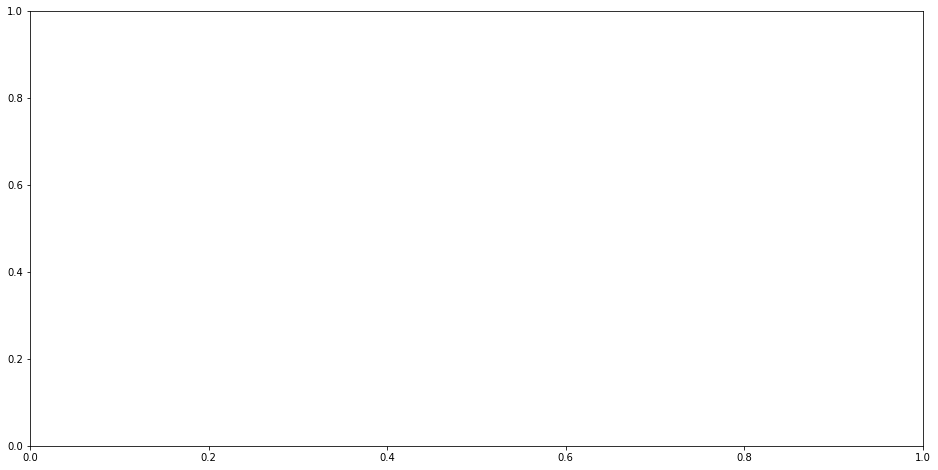

In [8]:
idx = 0

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.plot(range(len(AVG)), AVG)
ax.set_ylim([0, 1.1])

ax.plot([idx, idx], [0, 1.5], alpha=0.5)
 
print("avg:\t", AVG[idx])
print('frame:\t', FRAMES[idx])
FRAME = FRAMES[idx]

plt.show()